In [1]:
import pandas as pd
from pyace.preparedata import calc_min_distance,aseatoms_to_atomicenvironment
from pyace import *
from pyace.calculator import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataset_binary import *
import json
import seaborn as sns
import glob

%load_ext autoreload
%autoreload 2
from ase.io import read
plt.style.use('~/plot.mplstyle')
mpl.rcParams['figure.dpi'] = 100
from collections import Counter

In [2]:
def read_json(json_file):
    with open(json_file, 'r') as openfile:
        json_object = json.load(openfile)

    dist=np.asarray(json_object['distance'])
    en=np.asarray(json_object['energies'])
    
    return dist, en

#### Tuning potentials

In [3]:
bbasisconf = BBasisConfiguration("./output_potential.yaml")
bbasisconf.funcspecs_blocks
# calc=PyACECalculator("./output_potential.yaml")


[BBasisFunctionsSpecificationBlock(block_name='H', npoti=FinnisSinclair, fs_parameters=[1, 1, 1, 0.5],  nradmaxi=10, lmaxi=6, nradbaseij=15, radbase=SBessel, radparameters=[5.25], rcutij=6.4, dcutij=0.02, NameOfCutoffFunctionij=cos, radcoefficients=[[[[0.668976, -0.450611, 0.38083, -0.211596, 0.0802702, 0.0107948, -0.0217275, 0.048047, -0.0274138, 0.0297444, 0.0108841, 0.00396354, 0.0107773, -0.00596277, 0.00579943], [0.246859, -0.204168, 0.0813257, 0.0337511, -0.150751, 0.141196, -0.0824145, 0.0439894, -0.0356446, 0.0317318, -0.00399947, -0.0020814, -0.00119686, -0.000381225, -0.00121097], [0.161164, -0.151107, 0.120658, -0.0523821, -0.0451013, 0.0784961, -0.0549947, 0.0224351, -0.0388768, 0.0174479, -0.00840977, -0.00353211, 0.00198818, -0.00126089, -0.00682709], [0.194307, -0.164856, 0.105756, -0.00474052, -0.0678435, 0.106425, -0.0916863, 0.0453601, -0.0399144, 0.00980707, -0.00990567, -0.0112471, 0.00998568, -0.00865829, -0.00188032], [0.454311, -0.377209, 0.368763, 0.15458, -0.31

In [4]:
# H repulsion
bbasisconf.funcspecs_blocks[0].r_in = 0.2 # minimal interatomic distance in dataset
bbasisconf.funcspecs_blocks[0].delta_in = 0
bbasisconf.funcspecs_blocks[0].core_rep_parameters=[100, 0.2]
bbasisconf.funcspecs_blocks[0].rho_cut = 100
bbasisconf.funcspecs_blocks[0].drho_cut = 20


# ## H Si repulsion
bbasisconf.funcspecs_blocks[1].r_in = 0.3 # minimal interatomic distance in dataset
bbasisconf.funcspecs_blocks[1].delta_in = 0
bbasisconf.funcspecs_blocks[1].core_rep_parameters=[10, 0.3]
bbasisconf.funcspecs_blocks[1].rho_cut = 10
bbasisconf.funcspecs_blocks[1].drho_cut = 2

## Si repulsion
bbasisconf.funcspecs_blocks[2].r_in = 1.5 # minimal interatomic distance in dataset
bbasisconf.funcspecs_blocks[2].delta_in = 0.02 
bbasisconf.funcspecs_blocks[2].core_rep_parameters=[100, 1.4]
bbasisconf.funcspecs_blocks[2].rho_cut = 1000
bbasisconf.funcspecs_blocks[2].drho_cut = 200

## Si H repulsion
bbasisconf.funcspecs_blocks[3].r_in = 0.3 # minimal interatomic distance in dataset
bbasisconf.funcspecs_blocks[3].delta_in = 0
bbasisconf.funcspecs_blocks[3].core_rep_parameters=[10, 0.3]
bbasisconf.funcspecs_blocks[3].rho_cut = 10
bbasisconf.funcspecs_blocks[3].drho_cut = 2


bbasisconf.save("./output_potential_tuned_repulsion_vHH_vSiH.yaml")

#### Testing dimers

/u/vld/spet5633/software/miniconda3_test/envs/ace-gpu-24/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


(-10.0, 3.0)

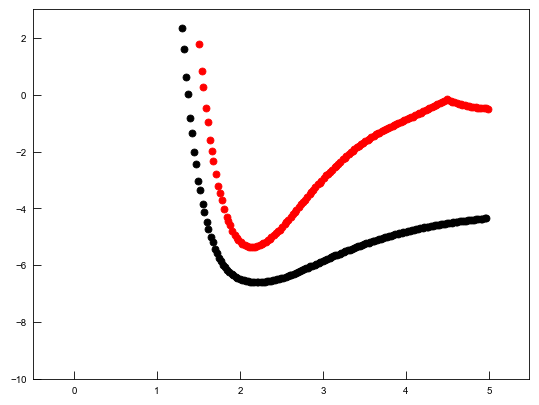

In [5]:
dimers=read('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/xyz/Si_Si.xyz', index=':')

dist_dft, dft_pred=read_json('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/DFT/Si_Si_dimer_dict.json')

# ACE potential
calc=PyACECalculator("./output_potential_tuned_repulsion_vHH_vSiH.yaml")
# calc=PyACECalculator("./output_potential.yaml")

ace_pred=[]
dist_ace=[]

for dimer in dimers:
    dimer.set_calculator(calc)
    ace_pred.append(dimer.get_potential_energy())
    dist_ace.append(dimer.get_distance(0,1))

plt.scatter(dist_ace, ace_pred, color='red')
plt.scatter(dist_dft, dft_pred, color='black')

plt.ylim(bottom=-10, top=3)
# plt.xlim(left=0.75, right=3)

/u/vld/spet5633/software/miniconda3_test/envs/ace-gpu-24/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


(-10.0, 200.0)

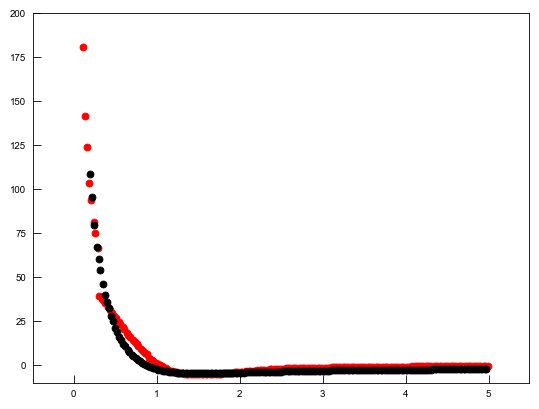

In [6]:
dimers=read('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/xyz/Si_H.xyz', index=':')

dist_dft, dft_pred=read_json('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/DFT/Si_H_dimer_dict.json')

# ACE potential
calc=PyACECalculator(".//output_potential_tuned_repulsion_vHH_vSiH.yaml")

ace_pred=[]
dist_ace=[]

for dimer in dimers:
    dimer.set_calculator(calc)
    ace_pred.append(dimer.get_potential_energy())
    dist_ace.append(dimer.get_distance(0,1))

plt.scatter(dist_ace, ace_pred, color='red')
plt.scatter(dist_dft, dft_pred, color='black')

plt.ylim(bottom=-10, top=200)
# plt.xlim(left=0.75, right=3)

([<matplotlib.axis.XTick at 0x7f3b5c04bb50>,
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2'),
  Text(1.4000000000000001, 0, '1.4'),
  Text(1.6, 0, '1.6'),
  Text(1.8, 0, '1.8'),
  Text(2.0, 0, '2.0'),
  Text(2.2, 0, '2.2'),
  Text(2.4000000000000004, 0, '2.4'),
  Text(2.6, 0, '2.6'),
  Text(2.8000000000000003, 0, '2.8'),
  Text(3.0, 0, '3.0'),
  Text(3.2, 0, '3.2'),
  Text(3.4000000000000004, 0, '3.4'),
  Text(3.6, 0, '3.6'),
  Text(3.8000000000000003, 0, '3.8'),
  Text(4.0, 0, '4.0'),
  Text(4.2, 0, '4.2'),
  Text(4.4, 0, '4.4'),
  Text(4.6000000000000005, 0, '4.6'),
  Text(4.800000000000001, 0, '4.8')])

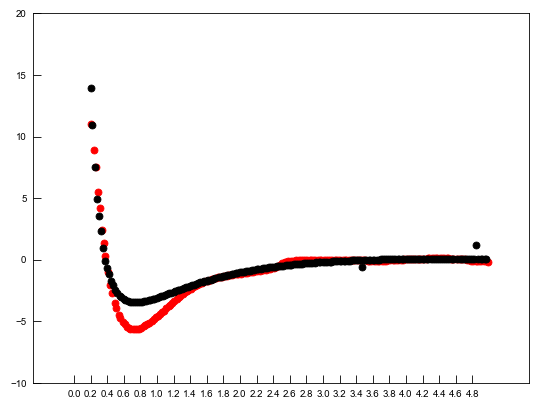

In [7]:
dimers=read('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/xyz/H_H.xyz', index=':')

dist_dft, dft_pred=read_json('/u/vld/spet5633/Silicon/a-Si_potential/DFT_1200eV/Testing/Scripts/dimers/DFT/H_H_dimer_dict.json')

# ACE potential
calc=PyACECalculator("./output_potential_tuned_repulsion_vHH_vSiH.yaml")
# calc=PyACECalculator("./output_potential.yaml")


ace_pred=[]
dist_ace=[]

for dimer in dimers:
    dimer.set_calculator(calc)
    ace_pred.append(dimer.get_potential_energy())
    dist_ace.append(dimer.get_distance(0,1))

plt.scatter(dist_ace, ace_pred, color='red')
plt.scatter(dist_dft, dft_pred, color='black')

plt.ylim(top=20, bottom=-10)
plt.xticks(np.arange(0,5,0.2))